# Exploring Auto-Learning for Unsupervised Tokenization Hyper-Parameters based on cross-split F1, Compression Factor and Normalized Anti-Entropy - English

## Summary
- Self-tuning based on cross-split F1 (CSF1), "Compression factor" (C%) and Normalized Anti-Entropy (~S) and their means and products:
  - provide high correlations with F1
    - CSF1 0.95
    - C% 0.83
    - ~S 0.94
    - mean(C%+~S) 0.93
    - prod(C%*~S) 0.93
  - make it possible to self-tune hyper parameters 
    - CSF1 = 1.0 => F1 = 0.95-0.99 
    - mean(C%+~S) >= 0.325 => F1 = 0.98-0.99
    - prod(C%*~S) >= 0.0966 => F1 = 0.98-0.99
    - ~S alone works worse than combination of the two => F1 = 0.89-0.95
    - C% alone does not work => F1 = 0.01

## TODO
- Evaluate on larger test corpus (use train for tuning but test for reference)


In [1]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path) 

#from importlib import reload  # Python 3.4+

import pickle
import pandas as pd

#force reimport
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']
if 'pygents.text' in sys.modules:
    del sys.modules['pygents.text']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.token' in sys.modules:
    del sys.modules['pygents.token']
if 'pygents.token_plot' in sys.modules:
    del sys.modules['pygents.token_plot']


from pygents.token import *
from pygents.text import *
from pygents.util import *
from pygents.plot import plot_bars, plot_dict, matrix_plot
from pygents.token_plot import *

In [2]:
path = '../../nlp/corpora/Chinese/'
test_df = pd.read_csv(os.path.join(path,'magicdata/zh_en_ru_100/CORPUS_ZH_EN_RU.txt'),delimiter='\t')
test_texts = list(test_df['en'])
print(len(test_texts))
test_df[['en']]

100


,en
0,What about medical insurance? As for my family...
1,"For those who have insurance, according to the..."
2,Need to realize the importance of having insur...
3,"In fact, this phenomenon is indeed very common..."
4,It is really necessary for this generation of ...
...,...
95,Ant Insurance does not only offer car insuranc...
96,"However, when buying a house, except for the d..."
97,This kind of financial investment has certain ...
98,"If your investment orientation is right, then ..."


## Basic test for Compression Ratio (C%) and Anormalized Shannon Anti-Entropy (~S)

In [3]:
ngram_params = [[1],[2],[3],[4]]
model_thresholds = [0]
token_thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
ref_tokenizer = DelimiterTokenizer()


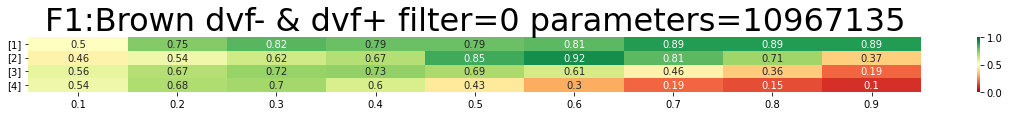

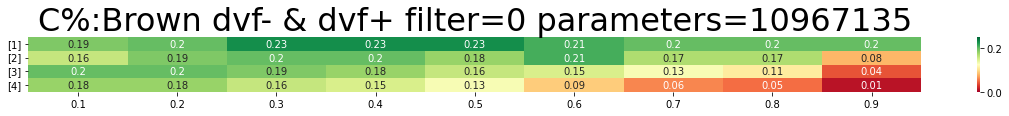

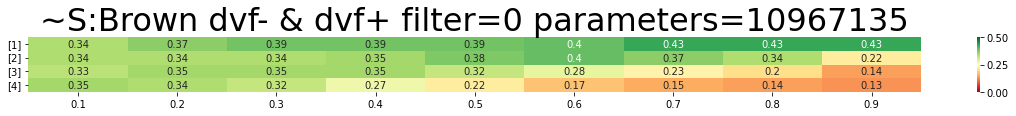

In [4]:
base = FreedomTokenizer(name='data/models/brown_nolines_chars_7a',max_n=7,mode='chars',debug=False)
title = 'Brown dvf- & dvf+'
metric_list = []
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(test_texts,ref_tokenizer,FreedomBasedTokenizer(base,'dvf-','dvf+'),
        ngram_params,token_thresholds,title="{} filter={} parameters={}".format(title,model_threshold,parameters))
    metric_list.extend([(model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base

In [5]:
m_df = pd.DataFrame(metric_list,columns=['MT','NG','TT','F1','C%','~S'])
m_df['C%+~S'] = (m_df['C%'] + m_df['~S'])/2
m_df['C%*~S'] = (m_df['C%'] * m_df['~S'])
print('F1 X C%',m_df['F1'].corr(m_df['C%']))
print('F1 X SH',m_df['F1'].corr(m_df['~S']))
print('F1 X C%+~S',m_df['F1'].corr(m_df['C%+~S']))
print('F1 X C%*~S',m_df['F1'].corr(m_df['C%*~S']))
m_df


F1 X C% 0.8896174806711008
F1 X SH 0.94480127511413
F1 X C%+~S 0.9365696835551208
F1 X C%*~S 0.9195969993295557


,MT,NG,TT,F1,C%,~S,C%+~S,C%*~S
0,0,[1],0.1,0.50,0.19,0.34,0.265,0.0646
1,0,[1],0.2,0.75,0.20,0.37,0.285,0.0740
2,0,[1],0.3,0.82,0.23,0.39,0.310,0.0897
3,0,[1],0.4,0.79,0.23,0.39,0.310,0.0897
4,0,[1],0.5,0.79,0.23,0.39,0.310,0.0897
5,0,[1],0.6,0.81,0.21,0.40,0.305,0.0840
6,0,[1],0.7,0.89,0.20,0.43,0.315,0.0860
7,0,[1],0.8,0.89,0.20,0.43,0.315,0.0860
8,0,[1],0.9,0.89,0.20,0.43,0.315,0.0860
9,0,[2],0.1,0.46,0.16,0.34,0.250,0.0544


## Explore self-tuning on Compression Ratio (C%) and Anormalized Shannon Anti-Entropy (~S)

In [6]:
ngram_params = [[1],[2],[3],[4],[5],[6],[7],[1,2],[2,3],[1,2,3],[1,2,3,4],[4,5,6,7],[1,2,3,4,5],[1,2,3,4,5,6,7]]
model_thresholds = [0,0.0001,0.001,0.01,0.1]
token_thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
ref_tokenizer = DelimiterTokenizer()


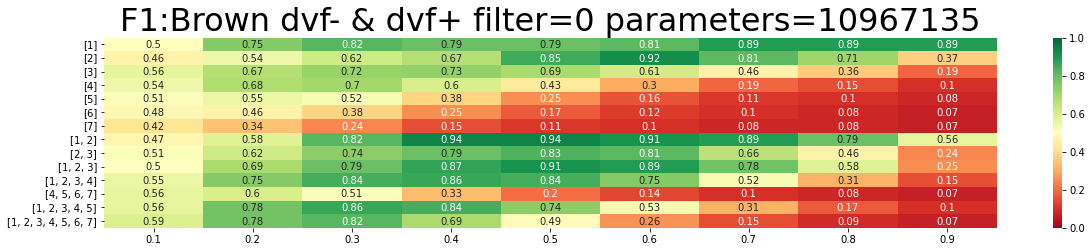

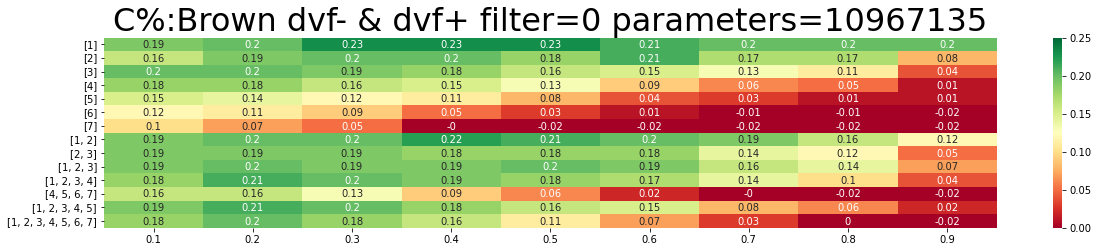

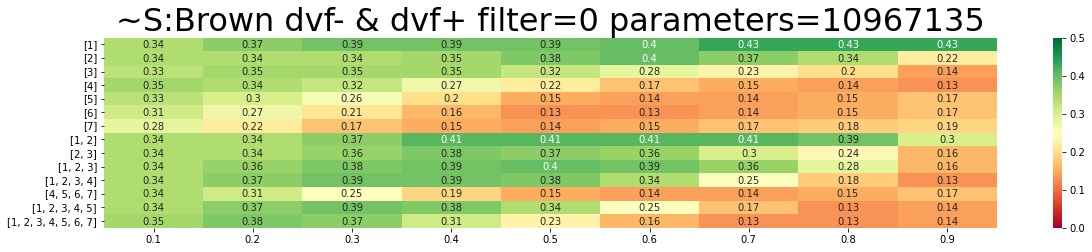

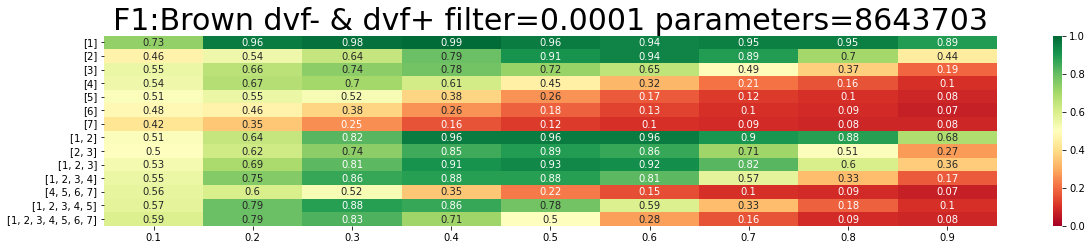

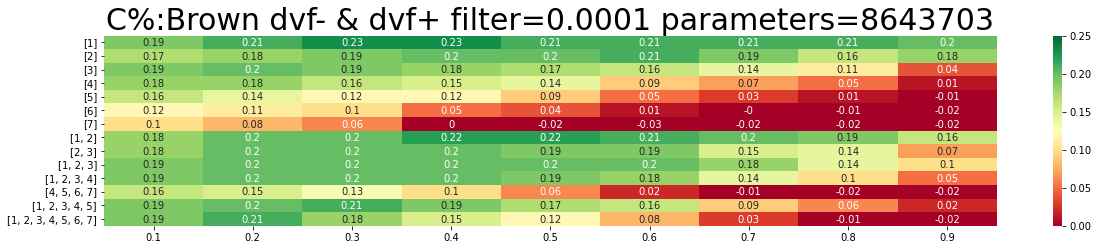

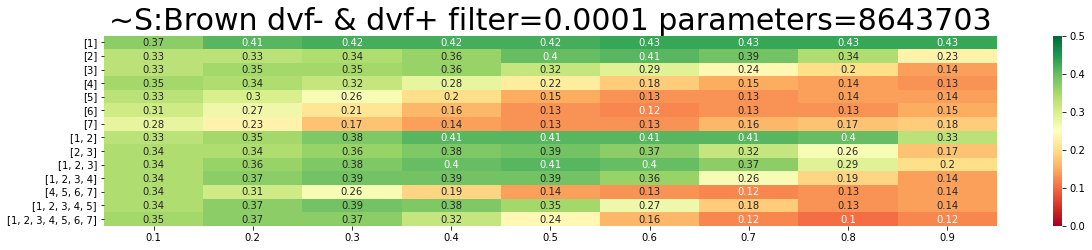

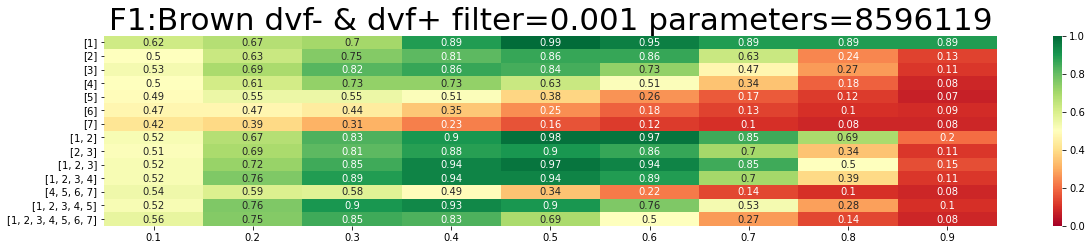

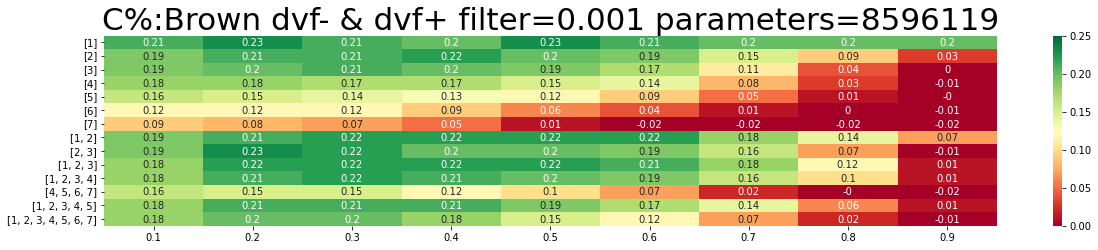

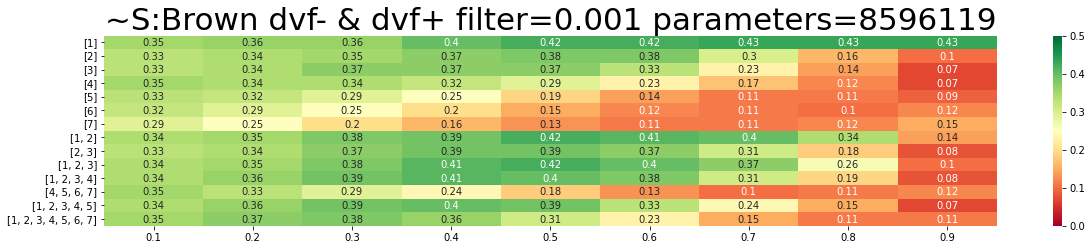

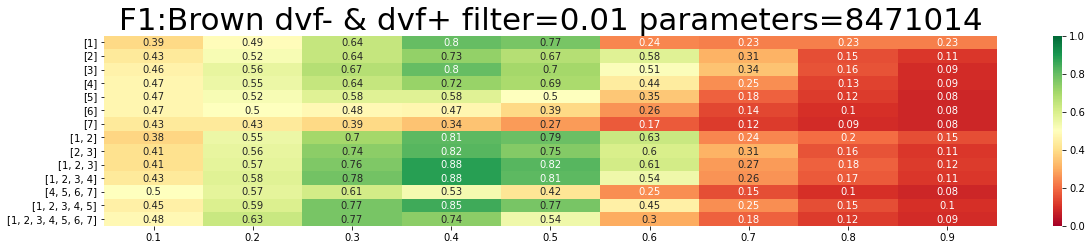

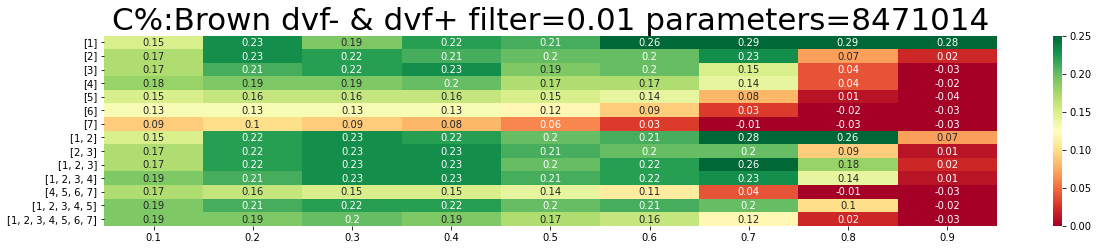

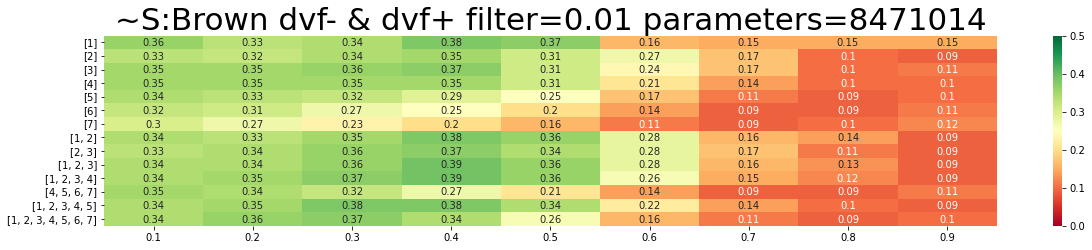

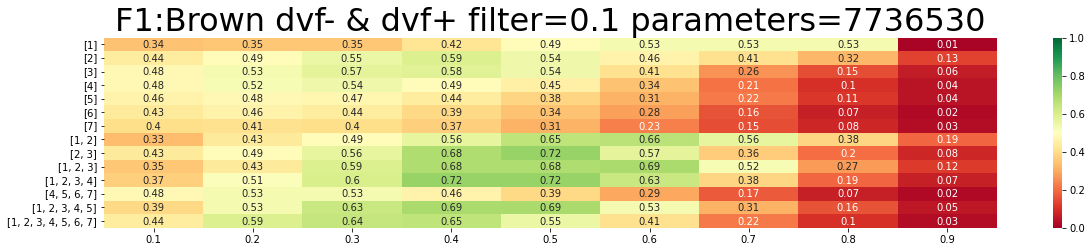

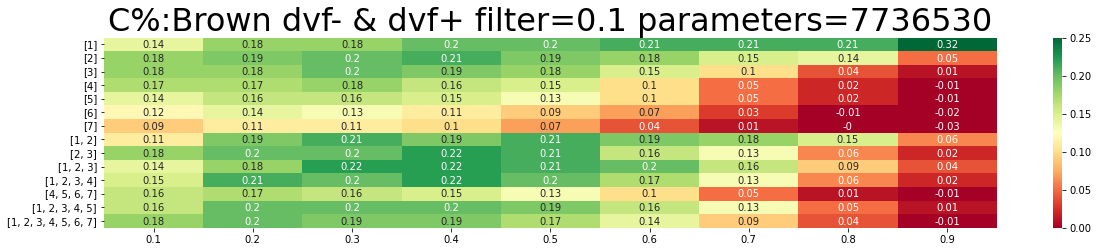

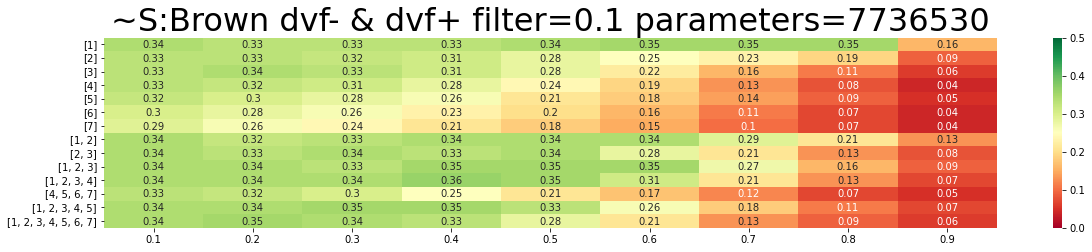

In [7]:
base = FreedomTokenizer(name='data/models/brown_nolines_chars_7a',max_n=7,mode='chars',debug=False)
title = 'Brown dvf- & dvf+'
metric_list = []
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(test_texts,ref_tokenizer,FreedomBasedTokenizer(base,'dvf-','dvf+'),
        ngram_params,token_thresholds,title="{} filter={} parameters={}".format(title,model_threshold,parameters))
    metric_list.extend([(model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base


In [8]:
len(metric_list)

630

In [34]:
m_df = pd.DataFrame(metric_list,columns=['MT','NG','TT','F1','C%','~S'])
m_df['C%+~S'] = (m_df['C%'] + m_df['~S'])/2
m_df['C%*~S'] = (m_df['C%'] * m_df['~S'])
print('F1 X C%',m_df['F1'].corr(m_df['C%']))
print('F1 X S~',m_df['F1'].corr(m_df['~S']))
print('F1 X C%+~S',m_df['F1'].corr(m_df['C%+~S']))
print('F1 X C%*~S',m_df['F1'].corr(m_df['C%*~S']))
m_df


F1 X C% 0.8341238143869498
F1 X S~ 0.9375411049593882
F1 X C%+~S 0.9286101137279753
F1 X C%*~S 0.9319211544615555


,MT,NG,TT,F1,C%,~S,C%+~S,C%*~S
0,0.0,[1],0.1,0.50,0.19,0.34,0.265,0.0646
1,0.0,[1],0.2,0.75,0.20,0.37,0.285,0.0740
2,0.0,[1],0.3,0.82,0.23,0.39,0.310,0.0897
3,0.0,[1],0.4,0.79,0.23,0.39,0.310,0.0897
4,0.0,[1],0.5,0.79,0.23,0.39,0.310,0.0897
...,...,...,...,...,...,...,...,...
625,0.1,"[1, 2, 3, 4, 5, 6, 7]",0.5,0.55,0.17,0.28,0.225,0.0476
626,0.1,"[1, 2, 3, 4, 5, 6, 7]",0.6,0.41,0.14,0.21,0.175,0.0294
627,0.1,"[1, 2, 3, 4, 5, 6, 7]",0.7,0.22,0.09,0.13,0.110,0.0117
628,0.1,"[1, 2, 3, 4, 5, 6, 7]",0.8,0.10,0.04,0.09,0.065,0.0036


In [35]:
m_df.sort_values(by=['C%','F1'],ascending=False)[:5]
# F1 = 0.01 - No way!


,MT,NG,TT,F1,C%,~S,C%+~S,C%*~S
512,0.10,[1],0.9,0.01,0.32,0.16,0.240,0.0512
384,0.01,[1],0.7,0.23,0.29,0.15,0.220,0.0435
385,0.01,[1],0.8,0.23,0.29,0.15,0.220,0.0435
447,0.01,"[1, 2]",0.7,0.24,0.28,0.16,0.220,0.0448
386,0.01,[1],0.9,0.23,0.28,0.15,0.215,0.0420


In [36]:
m_df.sort_values(by=['~S','F1'],ascending=False)[:15]
# F1 = 0.89-0.95 - Good, but not perfect


,MT,NG,TT,F1,C%,~S,C%+~S,C%*~S
132,0.0001,[1],0.7,0.95,0.21,0.43,0.320,0.0903
133,0.0001,[1],0.8,0.95,0.21,0.43,0.320,0.0903
131,0.0001,[1],0.6,0.94,0.21,0.43,0.320,0.0903
6,0.0000,[1],0.7,0.89,0.20,0.43,0.315,0.0860
7,0.0000,[1],0.8,0.89,0.20,0.43,0.315,0.0860
8,0.0000,[1],0.9,0.89,0.20,0.43,0.315,0.0860
134,0.0001,[1],0.9,0.89,0.20,0.43,0.315,0.0860
258,0.0010,[1],0.7,0.89,0.20,0.43,0.315,0.0860
259,0.0010,[1],0.8,0.89,0.20,0.43,0.315,0.0860
260,0.0010,[1],0.9,0.89,0.20,0.43,0.315,0.0860


In [37]:
m_df.sort_values(by=['~S','C%','F1'],ascending=False)[:5]
# F1 = 0.94-0.95 - Good, but not perfect


,MT,NG,TT,F1,C%,~S,C%+~S,C%*~S
132,0.0001,[1],0.7,0.95,0.21,0.43,0.320,0.0903
133,0.0001,[1],0.8,0.95,0.21,0.43,0.320,0.0903
131,0.0001,[1],0.6,0.94,0.21,0.43,0.320,0.0903
6,0.0000,[1],0.7,0.89,0.20,0.43,0.315,0.0860
7,0.0000,[1],0.8,0.89,0.20,0.43,0.315,0.0860


In [38]:
m_df.sort_values(by=['C%+~S','F1'],ascending=False)[:5]
# F1 = 0.98-0.99 - The best!


,MT,NG,TT,F1,C%,~S,C%+~S,C%*~S
129,0.0001,[1],0.4,0.99,0.23,0.42,0.325,0.0966
256,0.0010,[1],0.5,0.99,0.23,0.42,0.325,0.0966
128,0.0001,[1],0.3,0.98,0.23,0.42,0.325,0.0966
319,0.0010,"[1, 2]",0.5,0.98,0.22,0.42,0.320,0.0924
337,0.0010,"[1, 2, 3]",0.5,0.97,0.22,0.42,0.320,0.0924


In [39]:
m_df.sort_values(by=['C%*~S','F1'],ascending=False)[:5]
# F1 = 0.98-0.99 - The best!


,MT,NG,TT,F1,C%,~S,C%+~S,C%*~S
129,0.0001,[1],0.4,0.99,0.23,0.42,0.325,0.0966
256,0.0010,[1],0.5,0.99,0.23,0.42,0.325,0.0966
128,0.0001,[1],0.3,0.98,0.23,0.42,0.325,0.0966
319,0.0010,"[1, 2]",0.5,0.98,0.22,0.42,0.320,0.0924
337,0.0010,"[1, 2, 3]",0.5,0.97,0.22,0.42,0.320,0.0924


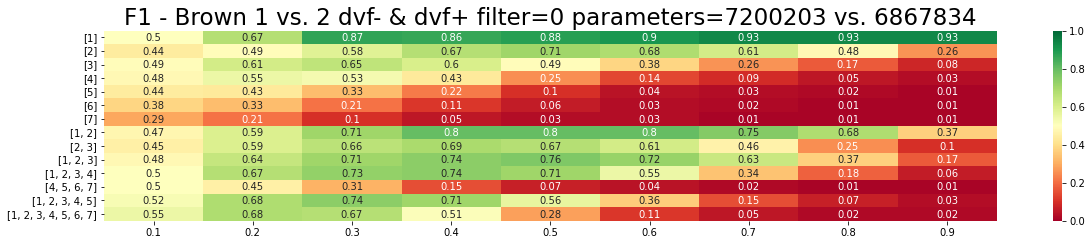

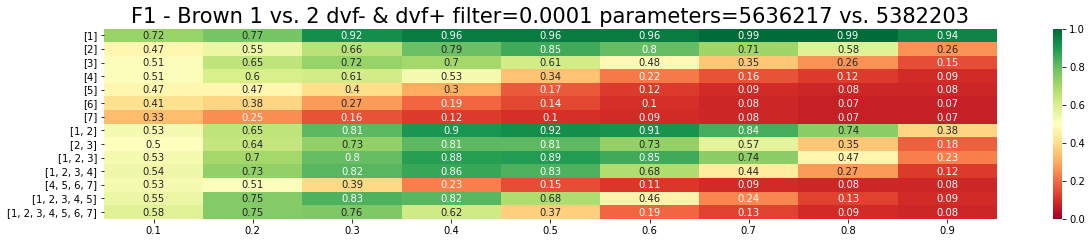

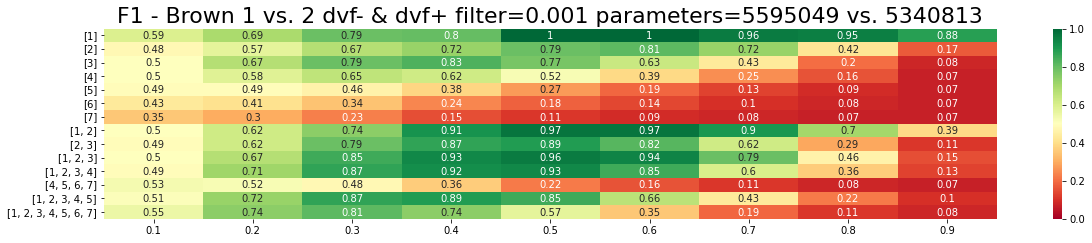

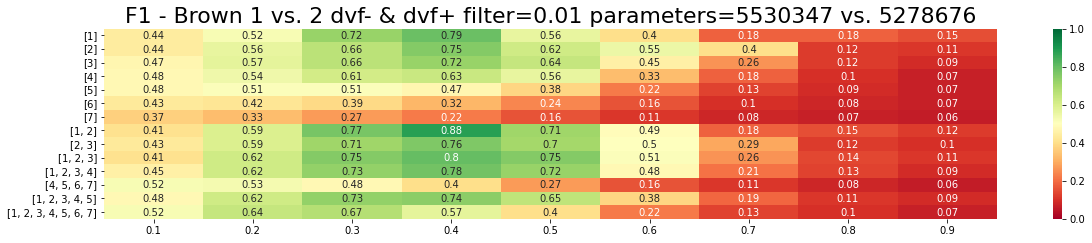

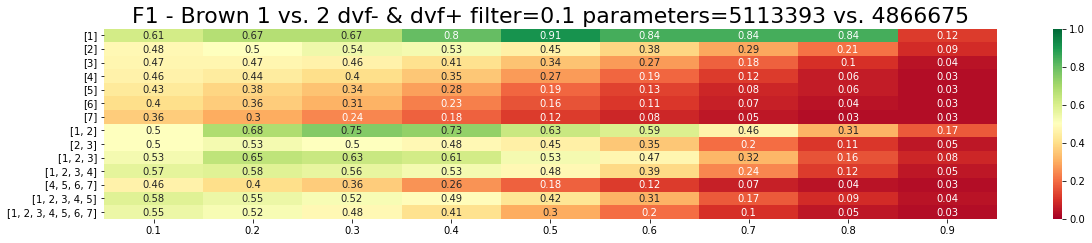

In [27]:
base1 = FreedomTokenizer(name='data/models/brown_chars_7_1',max_n=7,mode='chars',debug=False)
base2 = FreedomTokenizer(name='data/models/brown_chars_7_2',max_n=7,mode='chars',debug=False)
title = 'F1 - Brown 1 vs. 2 dvf- & dvf+'
cross_f_list = []
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base1.model,model_threshold)
        model_compress_with_loss(base2.model,model_threshold)
    parameters1 = base1.count_params()
    parameters2 = base2.count_params()
    metrics = evaluate_freedom_tokenizer_options(test_texts,
        FreedomBasedTokenizer(base1,'dvf-','dvf+'),
        FreedomBasedTokenizer(base2,'dvf-','dvf+'),
        ngram_params,token_thresholds,title="{} filter={} parameters={} vs. {}".format(title,model_threshold,parameters1,parameters2))
    cross_f_list.extend([(model_threshold,m[0],m[1],m[2]) for m in metrics])
del base1
del base2


In [32]:
m_cross_df = pd.DataFrame(cross_f_list,columns=['MT','NG','TT','F1-cross'])
print(m_df['F1'].corr(m_cross_df['F1-cross']))
m_df['F1-cross'] = m_cross_df['F1-cross']
m_df

0.947312128075061


,MT,NG,TT,F1,C%,~S,C%+~S,C%*~S,F1-cross
0,0.0,[1],0.1,0.50,0.19,0.34,0.265,0.0646,0.50
1,0.0,[1],0.2,0.75,0.20,0.37,0.285,0.0740,0.67
2,0.0,[1],0.3,0.82,0.23,0.39,0.310,0.0897,0.87
3,0.0,[1],0.4,0.79,0.23,0.39,0.310,0.0897,0.86
4,0.0,[1],0.5,0.79,0.23,0.39,0.310,0.0897,0.88
...,...,...,...,...,...,...,...,...,...
625,0.1,"[1, 2, 3, 4, 5, 6, 7]",0.5,0.55,0.17,0.28,0.225,0.0476,0.30
626,0.1,"[1, 2, 3, 4, 5, 6, 7]",0.6,0.41,0.14,0.21,0.175,0.0294,0.20
627,0.1,"[1, 2, 3, 4, 5, 6, 7]",0.7,0.22,0.09,0.13,0.110,0.0117,0.10
628,0.1,"[1, 2, 3, 4, 5, 6, 7]",0.8,0.10,0.04,0.09,0.065,0.0036,0.05


In [33]:
m_df.sort_values(by=['F1-cross','F1'],ascending=False)[:5]


,MT,NG,TT,F1,C%,~S,C%+~S,C%*~S,F1-cross
256,0.0010,[1],0.5,0.99,0.23,0.42,0.325,0.0966,1.00
257,0.0010,[1],0.6,0.95,0.21,0.42,0.315,0.0882,1.00
132,0.0001,[1],0.7,0.95,0.21,0.43,0.320,0.0903,0.99
133,0.0001,[1],0.8,0.95,0.21,0.43,0.320,0.0903,0.99
319,0.0010,"[1, 2]",0.5,0.98,0.22,0.42,0.320,0.0924,0.97


In [25]:
#TODO test the same on larger test corpus (subset of train!?)